## Documentation required info
---

Steps:
1. Load data and model
    * validate the model is the right one
2. Data Waterfall
3. Feature Importance
4. Generate SHAP plot
5. Segmeneted behaviors (should have been produced)

### Load Data and Model

In [1]:
import sys, os, json
sys.path.insert(1, "../../")
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import pickle as pkl
import seaborn as sns
import lightgbm as lgb
import src.monitoring.utils as mu
import src.monitoring.monitoring as mntr
import rdsutils.score_alignment as sa
import rdsutils

%matplotlib inline
plt.style.use('seaborn')

%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")

In [2]:
# train valid data
mmonth = "202104"
s3_base_path = f"s3://sofi-data-science/jxu/money-risk-models/customer-risk-model/monitor/{mmonth}"
train_df = pd.read_parquet(os.path.join(s3_base_path, "dev_train_scored.parquet"))
test_df = pd.read_parquet(os.path.join(s3_base_path, "dev_test_scored.parquet"))

In [3]:
train_df.sample_date.describe()

count                 4656758
unique                1123858
top       2020-12-31 00:00:00
freq                   652051
first     2019-02-01 00:00:00
last      2020-12-31 00:00:00
Name: sample_date, dtype: object

In [4]:
from smart_open import open

model_path = "s3://sofi-data-science/jxu/money-risk-models/models/customer_risk_refit_20201231_wo_ind.pkl"
with open(model_path, "rb") as f:
    clf = pkl.load(f)

In [31]:
clf.booster_.save_model('./artifacts/customer_risk_refit_20201231_wo_ind.txt')

#### Make sure it is the right model

By Plotting things

In [5]:
def plot_score_distr(df, score1, score2, ax, title):
    df[score1].hist(bins=50, alpha=0.4, label=score1, ax=ax)

    df[score2].hist(bins=50, alpha=0.4, label=score2, ax=ax)
    
    ax.set_title(title)
    ax.legend()
    

#### 2021-01-01 performance

,auc,ap,ks
fico_adjusted_pred,64.93,1.16,25.72
fraud_score_2,67.48,1.91,27.52
score_incumbent,68.62,10.02,23.51
score_wo_ind,77.92,18.29,39.35


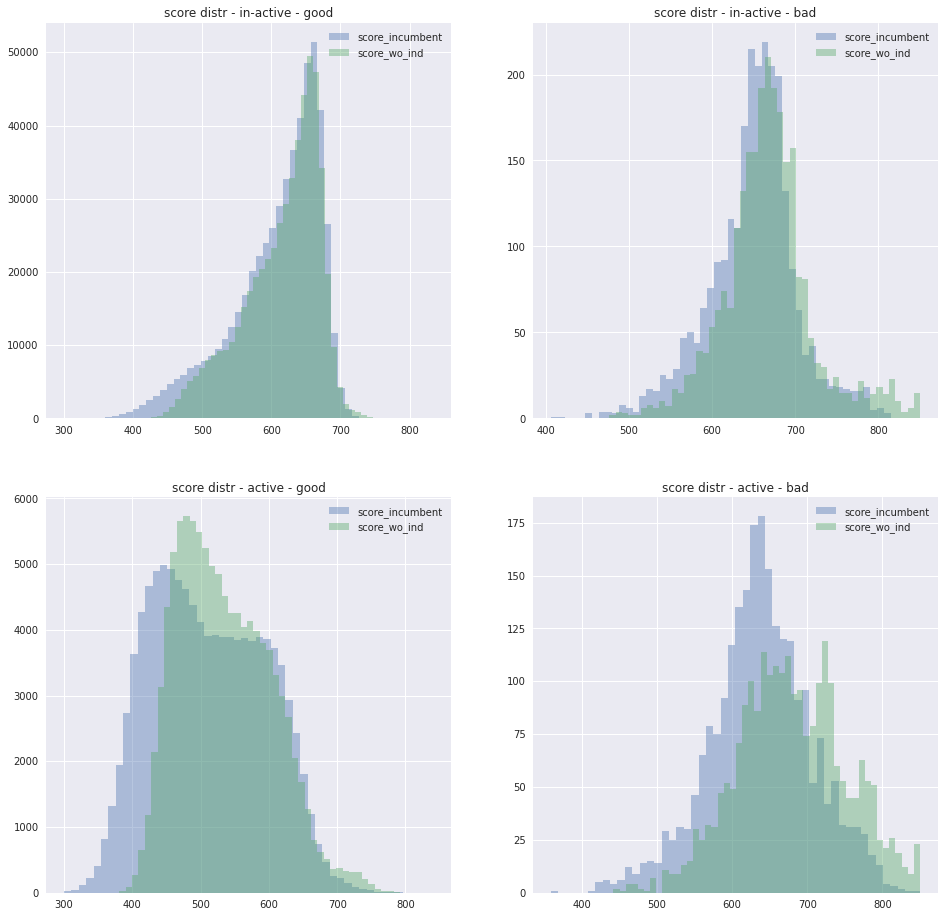

In [6]:
pred_cols = ['fico_adjusted_pred',
             'fraud_score_2',
             "score_incumbent", 
             "score_wo_ind"]
df_ = test_df[test_df.sample_date == pd.to_datetime("2021-01-01")]

report = mntr.get_pred_reports(df_, "target", pred_cols, dropna=True)
display(report)

# plot 4x4
score1 = "score_incumbent"
score2 = "score_wo_ind"

fig, axs = plt.subplots(2,2, figsize=(16, 16))

df_ = test_df[test_df.sample_date == pd.to_datetime("2021-01-01")]

df__ = df_[~df_.is_active & ~df_.target]  # inactive good accounts
plot_score_distr(df__, score1, score2, axs[0, 0], "score distr - in-active - good")

df__ = df_[~df_.is_active & df_.target]  # inactive bad accounts
plot_score_distr(df__, score1, score2, axs[0, 1], "score distr - in-active - bad")

df__ = df_[df_.is_active & ~df_.target]  # active good accounts
plot_score_distr(df__, score1, score2, axs[1, 0], "score distr - active - good")

df__ = df_[df_.is_active & df_.target]  # active bad accounts
plot_score_distr(df__, score1, score2, axs[1, 1], "score distr - active - bad")

plt.show()

In [7]:
test_df.sample_date.unique()

array(['2021-01-01T00:00:00.000000000', '2021-02-01T00:00:00.000000000'],
      dtype='datetime64[ns]')

if align, continue!

### Data Waterfall
---

In [2]:
train_start = pd.to_datetime("2019-01-16")
train_end = pd.to_datetime("2020-12-31")
valid_dates = [pd.to_datetime(d) for d in ["2021-01-01", "2021-02-01"]]

df = pd.read_feather("../../data/combined_all_features/combined_1623290211.feather")

In [3]:
train_df = df[df.sample_date.between(train_start, train_end)]
test_df = df[df.sample_date.isin(valid_dates)]
train_df.shape, test_df.shape

((4660562, 91), (1383116, 91))

In [4]:
def get_indeterminate_static(df):
    """
    indeterminate definitions

    1. bad but recovered account balance
    2. good but charged off
    3. good but recently down
    4. good but closed by risk
    5. good but restricted
    6. in-active
    """

    ind = (
        (df["nr_transactions_next_60d"] == 0)  # 6
        | (df["target"] & (df["latest_acc_bal"] > 0))  # 1
        | (
            ~df["target"]
            & (
                ~df["chg_wrt_off_date"].isna()  # 2
                | (df["latest_acc_bal"] < 0)  # 3
                | df["restricted_reason"].str.startswith("No")  # 5
                | df["closed_reason"].isin(  # 4
                    [
                        "Closed by SoFi - Risk Request",
                        "Closed by SoFi - Charge-Off / Write-Off",
                    ]
                )
            )
        )
    )
    return ind

def drop_account_with_no_trans_in_next_60d(df):
    condition = (df["nr_transactions_next_60d"] == 0)
    return df[~condition]
    
def drop_bad_but_pos_balance(df):
    condition = (df["target"] & (df["latest_acc_bal"] > 0))
    return df[~condition]

def drop_good_but_chg_wrt_off(df):
    condition = (~df[f'target'] & (~df["chg_wrt_off_date"].isna()))
    return df[~condition]

def drop_good_but_neg_balance(df):
    condition = (~df["target"] & (df["latest_acc_bal"] < 0))
    return df[~condition]

def drop_good_but_account_closed(df):
    condition = (~df["target"] & df["closed_reason"].isin(  # 4
                    [
                        "Closed by SoFi - Risk Request",
                        "Closed by SoFi - Charge-Off / Write-Off",
                    ]
                ))
    return df[~condition]

def drop_account_restricted_on_sample_date(df):
    condition = (~df["target"] & df["restricted_reason"].str.startswith("No"))
    return df[~condition]

In [5]:
from rdsutils.data_waterfall import DataWaterfallReport 

In [6]:
train_df[["is_static", "indeterminate"]].value_counts()

is_static  indeterminate
False      False            2246445
True       True             1663672
           False             665404
False      True               85041
dtype: int64

In [7]:
# static data
fns = [drop_account_with_no_trans_in_next_60d,
        drop_bad_but_pos_balance,
        drop_good_but_chg_wrt_off,
        drop_good_but_neg_balance,
        drop_good_but_account_closed,
        drop_account_restricted_on_sample_date]

wf = DataWaterfallReport(train_df[train_df.is_static], fns, 'target') 
waterfall = wf.get_report(True)
waterfall.to_csv("./artifacts/data_waterfall_static.csv")
waterfall

,# Excluded,# Remain,# False,# True
Starting Population,,2329076,2302799,26277
Drop Account With No Trans In Next 60D,1647826,681250,658819,22431
Drop Bad But Pos Balance,3551,677699,658819,18880
Drop Good But Chg Wrt Off,3647,674052,655172,18880
Drop Good But Neg Balance,1919,672133,653253,18880
Drop Good But Account Closed,1853,670280,651400,18880
Drop Account Restricted On Sample Date,4876,665404,646524,18880


In [8]:
def get_indeterminate_dynamic(df):
    """
    indeterminate definitions

    1. bad but recovered account balance
    2. good but charged off
    3. good but recently down
    4. good but closed by risk
    5. good but restricted
    """

    ind = ((df["target"] & (df["latest_acc_bal"] > 0)) 
           | (~df["target"] & (  # 1
        (~df["chg_wrt_off_date"].isna())  # 2
        | (df["latest_acc_bal"] < 0)  # 3
        | (
            df["closed_reason"].isin(  # 4
                [
                    "Closed by SoFi - Risk Request",
                    "Closed by SoFi - Charge-Off / Write-Off",
                ]
            )
        )
        | (df["restricted_reason"].str.startswith("No")))  # 5
    ))
    return ind


In [9]:
# dynamic data

fns = [drop_bad_but_pos_balance,
        drop_good_but_chg_wrt_off,
        drop_good_but_neg_balance,
        drop_good_but_account_closed,
        drop_account_restricted_on_sample_date]

wf = DataWaterfallReport(train_df[~train_df.is_static], fns, 'target') 
waterfall = wf.get_report(True)
waterfall.to_csv("./artifacts/data_waterfall_dynamic.csv")
waterfall

,# Excluded,# Remain,# False,# True
Starting Population,,2331486,2184114,147372
Drop Bad But Pos Balance,34098,2297388,2184114,113274
Drop Good But Chg Wrt Off,14948,2282440,2169166,113274
Drop Good But Neg Balance,7615,2274825,2161551,113274
Drop Good But Account Closed,7841,2266984,2153710,113274
Drop Account Restricted On Sample Date,20539,2246445,2133171,113274


In [10]:
train_df[~train_df.indeterminate].target.value_counts()

False    2779695
True      132154
Name: target, dtype: int64

### Feature Importance
---

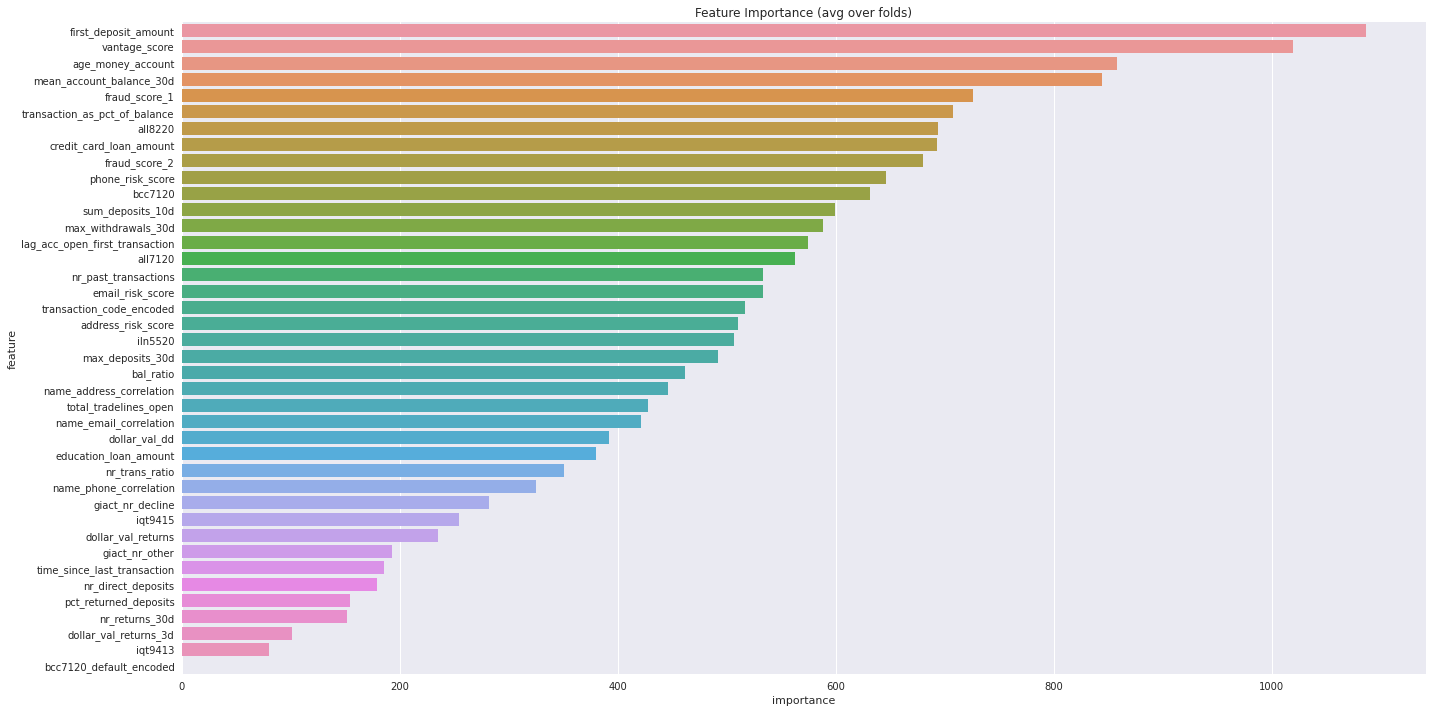

In [14]:
import rdsutils.plot as rdsplot
fig, axs = rdsplot.display_feature_importance(clf.feature_name_,
                                   clf.feature_importances_, 
                                   max_n_features=-1, figsize=(20,10)) 
fig.savefig('./artifacts/feature_importance.png')

### Generate SHAP plot
---

In [33]:
import math
import matplotlib.pyplot as plt
from tqdm import tqdm

def get_shap_dependence(df, shap_values, features, ncols=6, figsize=None, place_holder=True, **kwargs):
    """
    Build the partial dependence plot for a set of models and features.
    """
    nrows = math.ceil(len(features) / ncols)

    if figsize is None:
        figsize = (ncols * 6, nrows * 6)

    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    axs = axs.flatten()
    placeholder_i = 0
    for i in range(len(features)):
        feature = features[i]
        
#         if place_holder and feature == 'phone_risk_score':
#             placeholder_i = 1
        ax = axs[i]
        shap.dependence_plot(feature, shap_values, df, 
                             ax=ax, show=False, **kwargs)
        rlim = df[feature].quantile(0.98)
        llim = df[feature].quantile(0.02) - ((rlim - df[feature].quantile(0.02)) / 12)
            
        if rlim < np.inf and llim > -np.inf:
            ax.set_xlim(left=llim, right=rlim)
            
    return fig

In [16]:
features_by_imp = sorted(zip(clf.feature_importances_, clf.feature_name_), reverse=True)
features_by_imp = list(zip(*features_by_imp))[1]
features_by_imp = list(features_by_imp)

In [17]:
%%time 
import shap

shap.initjs()
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(train_df[clf.feature_name_])

CPU times: user 5h 24min 27s, sys: 3.14 s, total: 5h 24min 30s
Wall time: 4min 2s


CPU times: user 41.4 s, sys: 13 s, total: 54.4 s
Wall time: 54.4 s


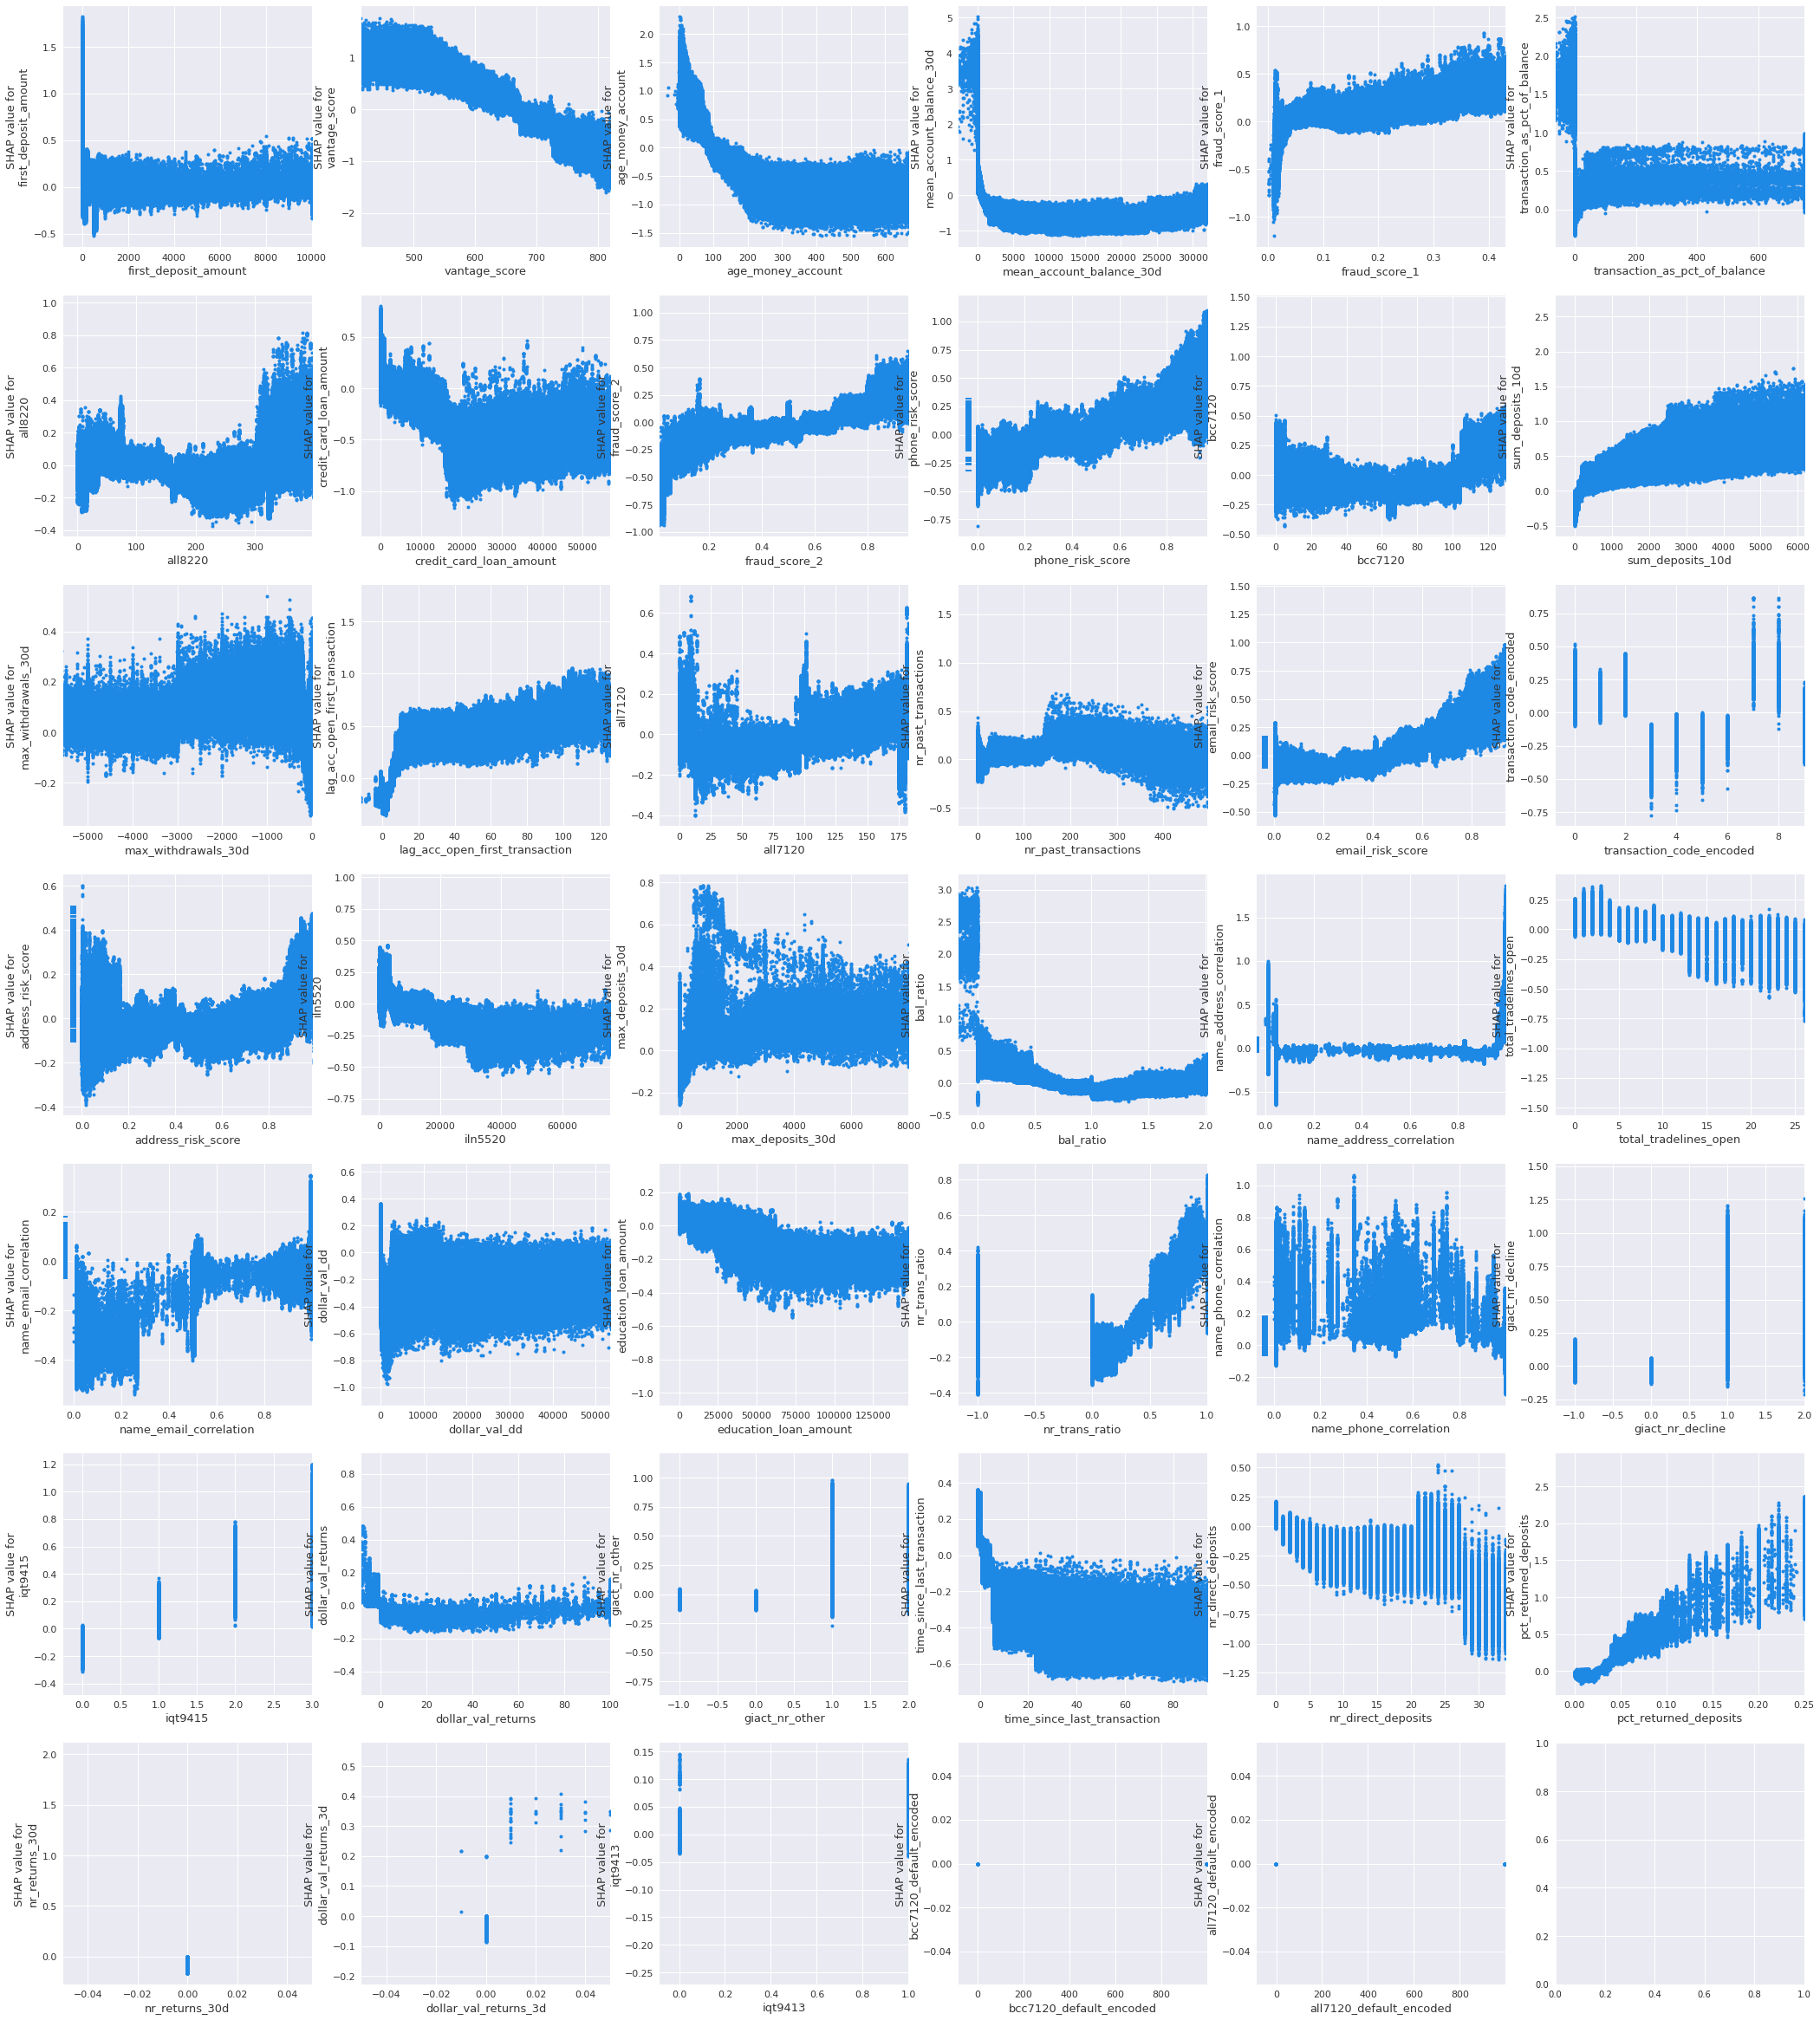

In [34]:
%time fig = get_shap_dependence(train_df[clf.feature_name_], shap_values[1], features_by_imp, interaction_index=None)

In [35]:
fig.savefig('./artifacts/shap_values.png')

### Segmented behavior
---

paths:
* `./artifacts/refitting/2021-01-01`
* `./artifacts/refitting/2021-02-01`